# New Hampshire Station Script

In [181]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math as m
from scipy import stats

Load functions for analysis

In [268]:
%run /Users/paulnicknish/Desktop/newEnglandSnowpack/reasearch_github/analysisFunctions.ipynb

In [183]:
dataPath1 = '/Users/paulnicknish/Desktop/newEnglandSnowpack/reasearch_github/nhStations/nhData1.csv'
dataPath2 = '/Users/paulnicknish/Desktop/newEnglandSnowpack/reasearch_github/nhStations/nhData2.csv'
dataPath3 = '/Users/paulnicknish/Desktop/newEnglandSnowpack/reasearch_github/nhStations/nhData3.csv'

Available station names in NH

- Lancaster
- Bethlehem
- Hanover
- Berlin
- North Stratford
- First Connecticut Lake
- Pinkham Notch
- Errol
- York Pond
- North Conway
- Mount Washington
- Jefferson
- Benton

In [184]:
# Read in the data
nhData1 = pd.read_csv(dataPath1)
nhData2 = pd.read_csv(dataPath2)
nhData3 = pd.read_csv(dataPath3)

nhDataFull = pd.concat((nhData1,nhData2,nhData3))#pd.concat((nhData3))

# Note that old (pre 1974) North Conway data has a different name. We fix that here
nhDataFull['NAME'] = nhDataFull['NAME'].str.replace('CONWAY 1 N, NH US','NORTH CONWAY, NH US')

In [185]:
# Select your station(s) of interest

stationNames = ['Pinkham Notch']

# convert these names to those used in the dataset
datasetNames = inputToDatasetName(stationNames)

In [186]:
# Create a dictionary of the original data for the selected stations

originalDataDict = {stationNames[i]:nhDataFull[nhDataFull.NAME==datasetNames[i]] for i in range(len(stationNames))}

In [187]:
# Create a dictionary for the different variables reported by the stations
    # Note: this cell is slow

snowDepthDict = {stationNames[i]:processFullDataset(originalDataDict[stationNames[i]],'SNWD',stationNames[i]) for i in range(len(stationNames))}
snowfallDict = {stationNames[i]:processFullDataset(originalDataDict[stationNames[i]],'SNOW',stationNames[i]) for i in range(len(stationNames))}
tMaxDict = {stationNames[i]:processFullDataset(originalDataDict[stationNames[i]],'TMAX',stationNames[i]) for i in range(len(stationNames))}
tMinDict = {stationNames[i]:processFullDataset(originalDataDict[stationNames[i]],'TMIN',stationNames[i]) for i in range(len(stationNames))}

In [188]:
## Calculate various analytical quantites for the data ##

## Snow Quantities ##

# Calculate snowfall to date
snowToDateDict = calcSnowToDate(snowfallDict)

# Calculate total snowfall for each year
seasonTotalSnowfallDict = calcSeasonTotalSnowfall(snowToDateDict)

# Caculate the maximum snowdepth
maxSnowDepthDict = calcMaxSnowDepth(snowDepthDict)

# Calculate THD of snow depth
thdDict = calcTHD_forDict(snowDepthDict)

# Number of days with snow depth above a certain threshold
thresholdSnwDepth = 50 # cm
numDaysAboveThresh = calcDaysAboveThresh(snowDepthDict,thresholdSnwDepth)

# Calculate SSM
ssmDict = calcSSM(snowDepthDict)

## Temperature Quantities ##

# Daily mean temperature
meanTemperatureDict = calcDailyMeanTemp(tMinDict,tMaxDict)

# THD of daily mean temperature
meanTempTHDDict = calcTHD_forDict(meanTemperatureDict)

# Calculate mean DJFM temperature
meanTempDJFMDict = calcMeanDJFMTemp(meanTemperatureDict)

# Calculate PPD in DJFM
ppdDict = calcPDDinDJFM(meanTemperatureDict)

# Plotting section

In [206]:
# Load plotting tools
%run /Users/paulnicknish/Desktop/newEnglandSnowpack/reasearch_github/plotSettings.ipynb

## Scatter plot
For comparing two variables, specified by `varX1` and `var2Y`. You can modify the list of stations you want to plot using the `stationNames` variable.

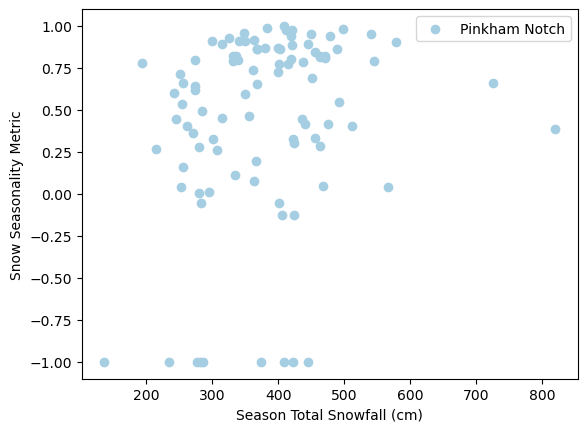

In [271]:
## Scatter plot to compare two variables ## 

var1X = seasonTotalSnowfallDict
var2Y = ssmDict

stationsToPlot = stationNames

# boolean for making legend
stationPlotted = 0

for istat,currStation in enumerate(stationsToPlot):
    
    stationColor = colorList[istat]
    stationMarker = markerList[istat]
    
    currStationX = var1X[currStation]
    currStationY = var2Y[currStation]
    
    for yearKey in currStationX.keys():
        
        if not stationPlotted:
            stationPlotted = 1
            plt.scatter(currStationX[yearKey],currStationY[yearKey],color=stationColor,label=currStation)                
        else:
            plt.scatter(currStationX[yearKey],currStationY[yearKey],color=stationColor)
    
    stationPlotted = 0
    
plt.legend()

# Set x and y labels
plt.xlabel(axisLabels(var1X));
plt.ylabel(axisLabels(var2Y));

## Time Series plot

This code is for plotting a time series of a yearly metric.
The x-axis is the year, and the y-axis the metric. The variable to plot is specified in the `varForTS` variable. You can modify the list of stations you want to plot using the `stationNames` variable.


Text(0.5, 0, 'Year')

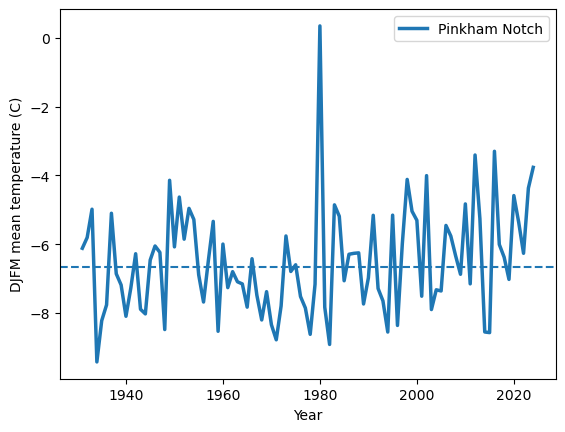

In [258]:
varForTS = meanTempDJFMDict
stationsToPlot = stationNames

for istat,currStation in enumerate(stationsToPlot):
    
    keysList = list(varForTS[currStation].keys())
    dataList = list(varForTS[currStation].values())
    
    yearsForPlot = keysList[1:] # first value is for the long-term mean
    dataForPlot = dataList[1:] # first value is for the long-term mean
    
    plt.plot(yearsForPlot,dataForPlot,label=currStation,linewidth=2.5)
    
    valForClimatology = dataList[0]
    plt.axhline(valForClimatology,linestyle = '--')
    
plt.legend()
plt.ylabel(axisLabels(varForTS))
plt.xlabel('Year')

## Line for each year plot

Specify *one* station using the `stationToPlot` variable. Specify the variable of interest using `varDataByYear`. Option to highlight a certain year using `highlightYear`.

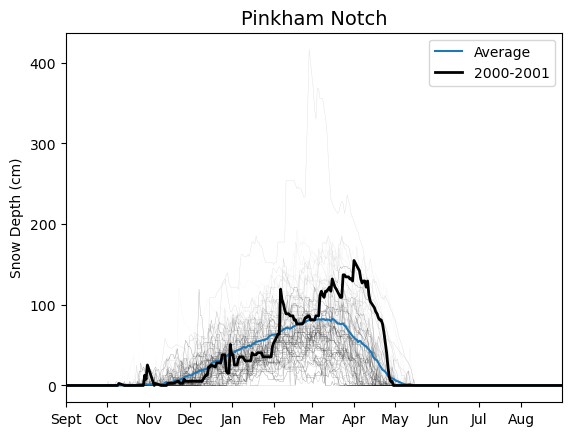

In [270]:
stationToPlot = 'Pinkham Notch'

varDataByYear = snowDepthDict
varDataByYear_atStation = varDataByYear[stationToPlot]

## if looking at snow depth, fill in missing values
snowDepthIsPlotted = 0 # boolean used for legend
if all(snowDepthDict[stationToPlot]['avg']['data'] == varDataByYear[stationToPlot]['avg']['data']):
    snowDepthIsPlotted = 1
    varDataByYear_atStation_fillNANs = copy.deepcopy(varDataByYear_atStation)
    for key in varDataByYear_atStation_fillNANs:
        varDataByYear_atStation_fillNANs[key]['data'] = fillInNans(varDataByYear_atStation_fillNANs[key]['data'])
    varDataByYear_atStation = varDataByYear_atStation_fillNANs

## Plot each year and the average over all years
for ikey,key in enumerate(list(varDataByYear_atStation.keys())):
    xVar = varDataByYear_atStation[key]['dates']
    yVar = varDataByYear_atStation[key]['data']
    
    if type(key) == np.int64:
        # Use gray shading for background plot
        plt.plot(xVar,yVar,c=greyShades[ikey],linewidth = .25,alpha = .5,zorder=0)
    elif key == 'avg':
        # Plot the average snow depth over the course of the year
        plt.plot(xVar,yVar,linewidth=1.5,label='Average')
    
# option to plot a highlighted year

highlightedYear = 2001

if highlightedYear != None:
    highlightedYearDates = varDataByYear_atStation[highlightedYear]['dates']
    highlightedYearData = varDataByYear_atStation[highlightedYear]['data']
    
    plt.plot(highlightedYearDates,highlightedYearData,
             label='{}-{}'.format(highlightedYear-1,highlightedYear),
             c='k',linewidth=2)

# set x-axis
adjustToSept1 = 122 # want sept 1 to be day 1
plt.xticks([dayOfYear('2000-09-01')+adjustToSept1-366, dayOfYear('2000-10-01')+adjustToSept1-366,
            dayOfYear('2000-11-01')+adjustToSept1-366, dayOfYear('2000-12-01')+adjustToSept1-366,
            dayOfYear('2001-01-01')+adjustToSept1, dayOfYear('2001-02-01')+adjustToSept1,
            dayOfYear('2001-03-01')+adjustToSept1, dayOfYear('2001-04-01')+adjustToSept1,
            dayOfYear('2001-05-01')+adjustToSept1, dayOfYear('2000-06-01')+adjustToSept1,
            dayOfYear('2000-07-01')+adjustToSept1, dayOfYear('2000-08-01')+adjustToSept1],
           ['Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']);
plt.xlim((1,366))

# set y-axis
if snowDepthIsPlotted:
    plt.ylabel('Snow Depth (cm)')
else:
    plt.ylabel(axisLabels(varDataByYear))
    

plt.title(stationToPlot)

plt.legend()